In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Attention, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import warnings
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

print("Checking/downloading NLTK resources...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)   
nltk.download('stopwords', quiet=True)

warnings.filterwarnings('ignore')

# Load Data
train_df = pd.read_csv(r"C:/Desktop/ML bootcamp/multi-class-sentiment-analysis/data/train/train.tsv", sep='\t', header=0)
test_df = pd.read_csv(r"C:/Desktop/ML bootcamp/multi-class-sentiment-analysis/data/test/test.tsv", sep='\t', header=0)

print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Checking/downloading NLTK resources...
Training data: (156060, 4)
Test data: (66292, 3)


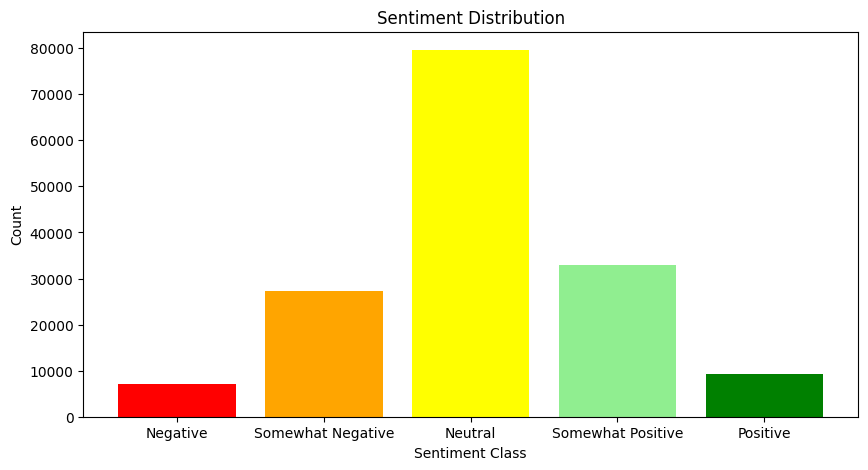

In [2]:
# EDA - Sentiment Distribution
plt.figure(figsize=(10, 5))
sentiment_counts = train_df['Sentiment'].value_counts().sort_index()
plt.bar(range(5), sentiment_counts.values, color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.xticks(range(5), ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive'])
plt.savefig("sentiment_distribution.png")
plt.show()

In [3]:
# We balance the classes so the model learns positive and negative features equally.
def balance_data(df):
    target_size = 20000 
    balanced_df = pd.DataFrame()
    
    for i in range(5):
        class_subset = df[df['Sentiment'] == i]
        resampled_class = resample(class_subset,
                                   replace=True,        
                                   n_samples=target_size, 
                                   random_state=42)
        balanced_df = pd.concat([balanced_df, resampled_class])
    
    return balanced_df.sample(frac=1).reset_index(drop=True) 

train_df_balanced = balance_data(train_df)
print("Balanced Sentiment distribution:")
print(train_df_balanced['Sentiment'].value_counts().sort_index())

Balanced Sentiment distribution:
Sentiment
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64


In [4]:
# Text Preprocessing with NLTK
stop_words = set(stopwords.words('english'))

contractions = {
    "n't": " not", "'re": " are", "'s": " is", "'d": " would",
    "'ll": " will", "'ve": " have", "'m": " am"
}

def clean_text(text):
    text = str(text).lower()
    # Expand contractions
    for contr, full in contractions.items():
        text = text.replace(contr, full)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize & remove stopwords
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

print("Cleaning phrases...")
train_df['clean_phrase'] = train_df['Phrase'].apply(clean_text)
test_df['clean_phrase']  = test_df['Phrase'].apply(clean_text)

# Initialize preprocessor
max_features = 30000
max_len = 100
tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['Phrase'].apply(clean_text))

X_train = tokenizer.texts_to_sequences(train_df['Phrase'].apply(clean_text))
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
y_train = train_df['Sentiment'].values

# Train-Validation Split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

Cleaning phrases...


In [5]:
# Train Multiple Models
models = {}
histories = {}
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

# BiLSTM
def create_bilstm(vocab_size, max_len=100):
    inputs = Input(shape=(max_len,))
    embedding = Embedding(vocab_size, 100, input_length=max_len)(inputs)
    bilstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(embedding)
    attention = Attention()([bilstm, bilstm])
    pooled = GlobalMaxPooling1D()(attention)
    dense1 = Dense(128, activation='relu')(pooled)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(5, activation='softmax')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model1 = create_bilstm(len(tokenizer.word_index) + 1)
history1 = model1.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split),
                     epochs=30, batch_size=64, callbacks=callbacks, verbose=1)
models['BiLSTM'] = model1
histories['BiLSTM'] = history1

# CNN-LSTM
def create_cnn_lstm(vocab_size, max_len=100):
    inputs = Input(shape=(max_len,))
    embedding = Embedding(vocab_size, 100, input_length=max_len)(inputs)
    conv = tf.keras.layers.Conv1D(128, 5, activation='relu')(embedding)
    pool = tf.keras.layers.MaxPooling1D(5)(conv)
    lstm = LSTM(64)(pool)
    outputs = Dense(5, activation='softmax')(lstm)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model2 = create_cnn_lstm(len(tokenizer.word_index) + 1)
history2 = model2.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split),
                     epochs=30, batch_size=64, callbacks=callbacks, verbose=1)
models['CNN_LSTM'] = model2
histories['CNN_LSTM'] = history2

Epoch 1/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 168s 85ms/step - accuracy: 0.5759 - loss: 1.0805 - val_accuracy: 0.6365 - val_loss: 0.8891 - learning_rate: 0.0010
Epoch 2/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 163s 84ms/step - accuracy: 0.6614 - loss: 0.8441 - val_accuracy: 0.6597 - val_loss: 0.8410 - learning_rate: 0.0010
Epoch 3/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 168s 86ms/step - accuracy: 0.6894 - loss: 0.7741 - val_accuracy: 0.6650 - val_loss: 0.8294 - learning_rate: 0.0010
Epoch 4/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 170s 87ms/step - accuracy: 0.7051 - loss: 0.7318 - val_accuracy: 0.6646 - val_loss: 0.8345 - learning_rate: 0.0010
Epoch 5/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 177s 91ms/step - accuracy: 0.7138 - loss: 0.6987 - val_accuracy: 0.6588 - val_loss: 0.8466 - learning_rate: 0.0010
Epoch 6/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 214s 110ms/step - accuracy: 0.7453 - loss: 0.6233 - val_accuracy: 0.6606 - val_loss: 0.8831 - learning_rate: 2.0000e-04
Epoch 7/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 280s 143ms/


==================== Evaluating Model: BiLSTM ====================
976/976 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step
Overall Accuracy: 0.6650

Detailed Sentiment Analysis Report:
              precision    recall  f1-score   support

    Negative       0.54      0.33      0.41      1414
Somewhat Neg       0.55      0.52      0.53      5455
     Neutral       0.73      0.84      0.78     15917
Somewhat Pos       0.59      0.52      0.55      6585
    Positive       0.60      0.40      0.48      1841

    accuracy                           0.66     31212
   macro avg       0.60      0.52      0.55     31212
weighted avg       0.65      0.66      0.65     31212



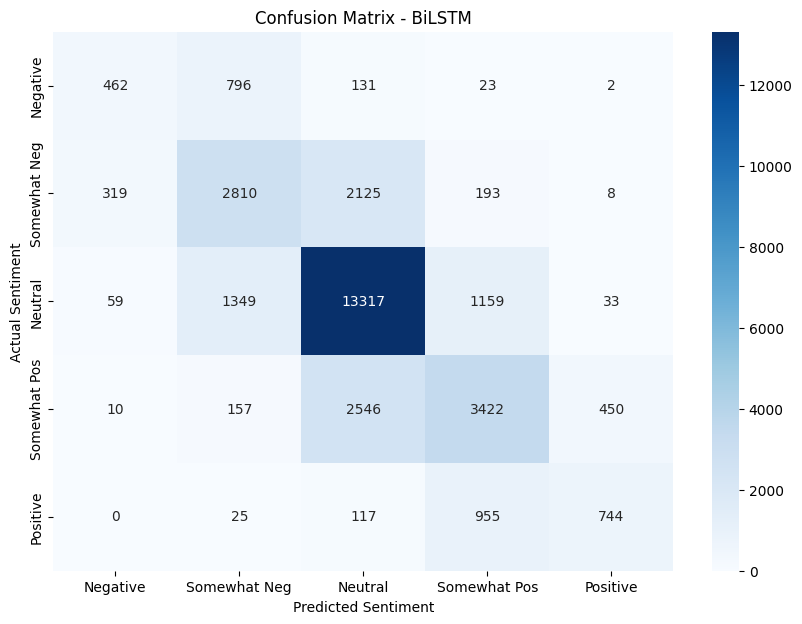


==================== Evaluating Model: CNN_LSTM ====================
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Overall Accuracy: 0.6422

Detailed Sentiment Analysis Report:
              precision    recall  f1-score   support

    Negative       0.59      0.06      0.10      1414
Somewhat Neg       0.51      0.50      0.50      5455
     Neutral       0.72      0.82      0.77     15917
Somewhat Pos       0.54      0.55      0.55      6585
    Positive       0.57      0.28      0.38      1841

    accuracy                           0.64     31212
   macro avg       0.59      0.44      0.46     31212
weighted avg       0.63      0.64      0.62     31212



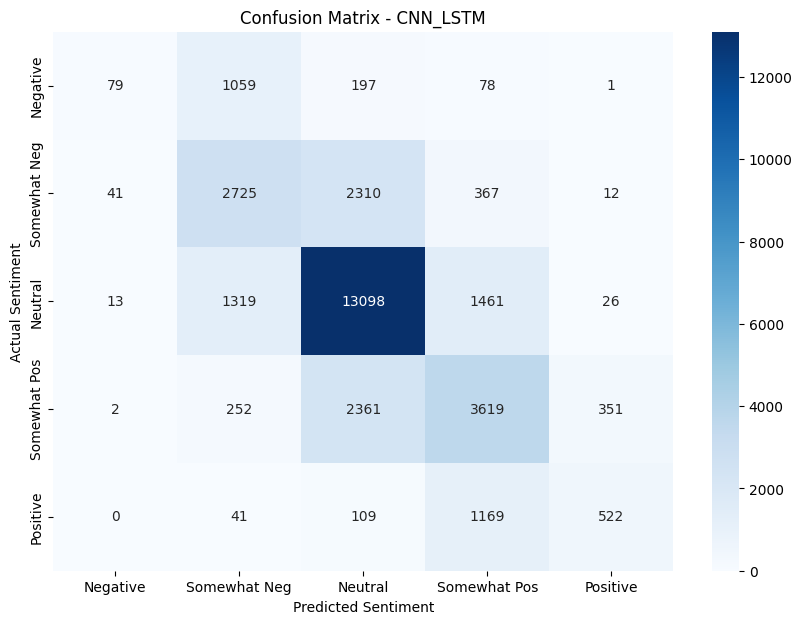

In [6]:
# Model Evaluation
results = {}
for name, model in models.items():
    print(f"\n{'='*20} Evaluating Model: {name} {'='*20}")
    
    y_pred_probs = model.predict(X_val_split)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    accuracy = accuracy_score(y_val_split, y_pred)
    results[name] = accuracy
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    print("\nDetailed Sentiment Analysis Report:")
    target_names = ['Negative', 'Somewhat Neg', 'Neutral', 'Somewhat Pos', 'Positive']
    print(classification_report(y_val_split, y_pred, target_names=target_names))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(10, 7))
    cm = confusion_matrix(y_val_split, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual Sentiment')
    plt.xlabel('Predicted Sentiment')
    plt.show()

In [7]:
# Save Best Model
best_model = max(results.keys(), key=lambda x: results[x])
models[best_model].save('models/best_model.h5')
import pickle
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)